# Task 2.2: Advanced Bayesian Modeling - Detecting Changes in Volatility

In [4]:
!pip install pymc arviz --quiet


In [6]:
# 🧮 Imports
import pymc as pm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az
import seaborn as sns

plt.style.use("seaborn-v0_8-darkgrid")


In [8]:
from google.colab import files
uploaded = files.upload()


Saving BrentOilPrices.csv to BrentOilPrices.csv
Saving event_data.csv to event_data.csv


In [9]:
# 📥 Load Data
df = pd.read_csv("BrentOilPrices.csv", parse_dates=["Date"])
df = df.sort_values("Date")
df["Log_Return"] = np.log(df["Price"]).diff()
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)
log_returns = df["Log_Return"].values


/tmp/ipython-input-627167362.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv("BrentOilPrices.csv", parse_dates=["Date"])


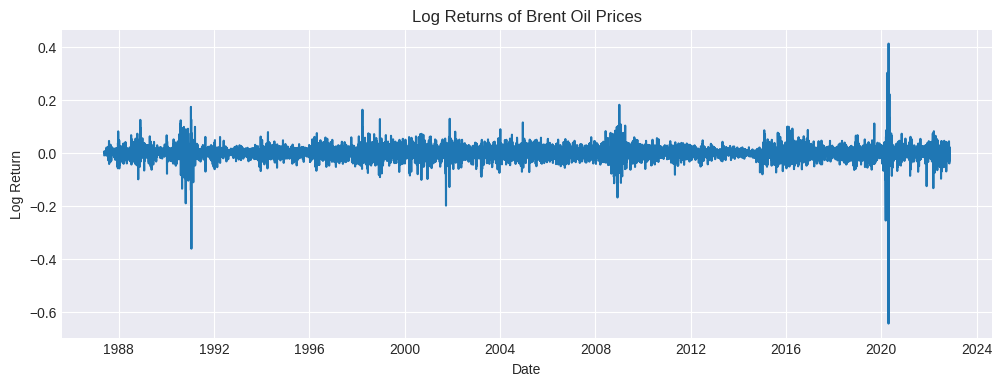

In [10]:
# 📈 Visualize Log Returns
plt.figure(figsize=(12,4))
plt.plot(df["Date"], df["Log_Return"], label="Log Returns")
plt.title("Log Returns of Brent Oil Prices")
plt.xlabel("Date")
plt.ylabel("Log Return")
plt.show()


In [11]:
# 🔍 Define and run PyMC v4 model
with pm.Model() as model:
    tau = pm.DiscreteUniform("tau", lower=0, upper=len(log_returns) - 1)

    mu1 = pm.Normal("mu1", mu=0, sigma=1)
    mu2 = pm.Normal("mu2", mu=0, sigma=1)

    sigma1 = pm.HalfNormal("sigma1", sigma=1)
    sigma2 = pm.HalfNormal("sigma2", sigma=1)

    mu = pm.math.switch(tau > np.arange(len(log_returns)), mu1, mu2)
    sigma = pm.math.switch(tau > np.arange(len(log_returns)), sigma1, sigma2)

    obs = pm.Normal("obs", mu=mu, sigma=sigma, observed=log_returns)

    trace = pm.sample(2000, tune=1000, return_inferencedata=True, random_seed=42)


Output()

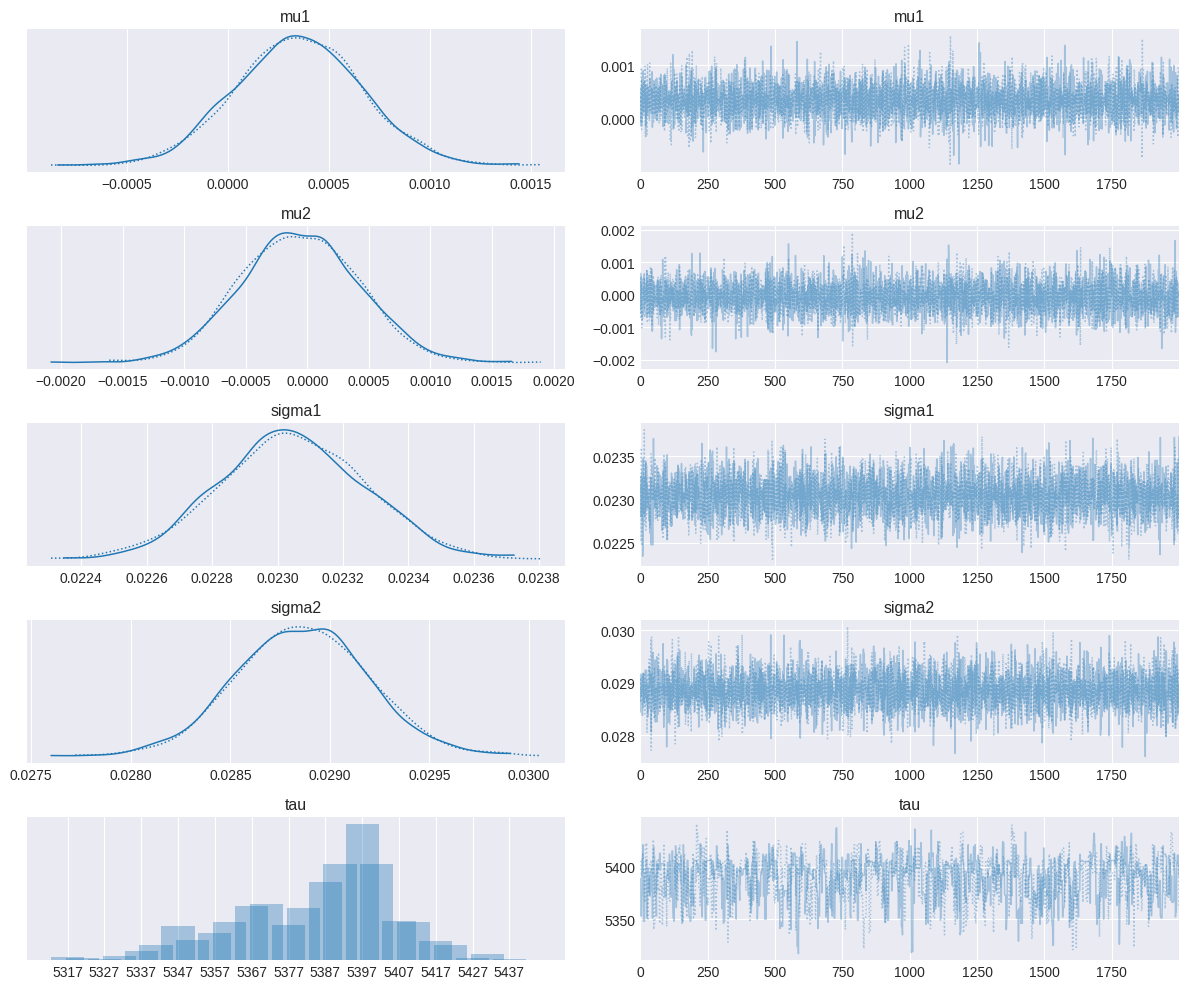

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu1,0.000,0.000,-0.000,0.001,0.000,0.000,6086.0,2865.0,1.0
mu2,-0.000,0.000,-0.001,0.001,0.000,0.000,7057.0,3256.0,1.0
sigma1,0.023,0.000,0.023,0.023,0.000,0.000,5482.0,3113.0,1.0
sigma2,0.029,0.000,0.028,0.029,0.000,0.000,6290.0,3266.0,1.0
tau,5389.264,20.896,5348.000,5422.000,0.816,0.523,688.0,917.0,1.0


In [12]:
# 📊 Posterior Summary
az.plot_trace(trace, var_names=["mu1", "mu2", "sigma1", "sigma2", "tau"])
plt.tight_layout()
plt.show()

summary = az.summary(trace, var_names=["mu1", "mu2", "sigma1", "sigma2", "tau"])
summary


In [13]:
# 📅 Extract Most Likely Change Point Date
most_likely_tau = int(trace.posterior["tau"].mean().values)
change_date = df.iloc[most_likely_tau]["Date"]
print(f"📅 Most Likely Change Point Date: {change_date.date()}")


📅 Most Likely Change Point Date: 2008-07-29


→ Mean Before: 0.000354 | Std Dev (Volatility): 0.023034
→ Mean After:  -0.000082 | Std Dev (Volatility): 0.028856


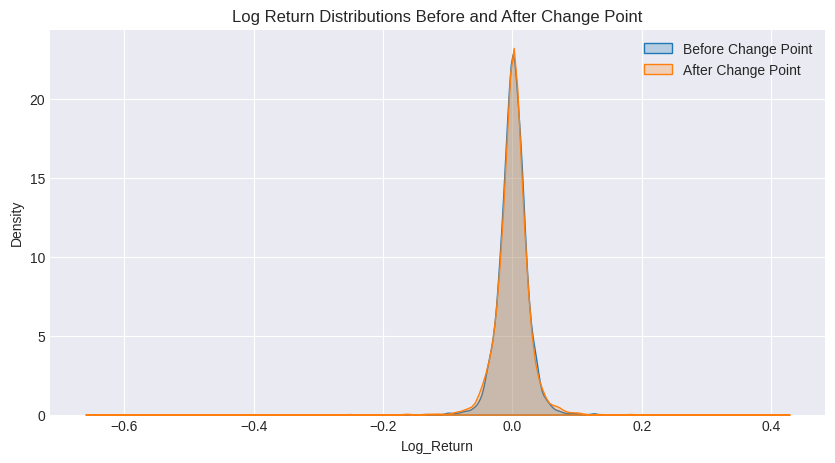

In [14]:
# 📉 Compare Volatility and Mean Before/After
before_cp = df.loc[:most_likely_tau, "Log_Return"]
after_cp = df.loc[most_likely_tau+1:, "Log_Return"]

print(f"→ Mean Before: {before_cp.mean():.6f} | Std Dev (Volatility): {before_cp.std():.6f}")
print(f"→ Mean After:  {after_cp.mean():.6f} | Std Dev (Volatility): {after_cp.std():.6f}")

# KDE plots
plt.figure(figsize=(10,5))
sns.kdeplot(before_cp, fill=True, label="Before Change Point")
sns.kdeplot(after_cp, fill=True, label="After Change Point")
plt.title("Log Return Distributions Before and After Change Point")
plt.legend()
plt.show()
